# Backpropagation algorithm

In [1]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from IPython.display import display
import datetime as dt 
import autograd.numpy as anp
from autograd import grad
import random

c = 299792458  # Speed of light in m/s§

In [2]:
# Use definition as in the Extractor class

def H_th_function(n, w, length):
    '''
    Inputs
    ------
    n: refractive index
    w: frequency of light being propagated
    length: length of the sample we are modelling
    
    outputs
    -------
    returns: output for the transfer function

    Method
    ------
    Equation for transfer function derived from [Input source here]

    '''
    return (4 * n) / ((n + 1) ** 2) * anp.exp(-1j * (n - 1) * w * length/ c)

# Function to round to significant figures
def round_to_sig_figs(value, sig_figs):
    if value == 0:
        return 0
    return round(value, sig_figs - int(f"{value:.1e}".split('e')[1]) - 1)


# Define loss functions
def abs_tf_loss(H_exp, H):
    return np.mean(np.abs(H_exp - H))

def phase_tf_loss(phase_exp, phase):
    return np.mean(np.abs(phase_exp - phase))

def loss(H_exp, H, phase_exp, phase):
    return abs_tf_loss(H_exp, H) + phase_tf_loss(phase_exp, phase)

In [3]:
# TODO: generate random n,k,d for backprop algo, add noise to this.

# frequency range
interp = 2**6
freqs_THz = np.linspace(0.1, 5, interp)   # 0-5 THz 
freqs = freqs_THz * 1e12
freqs_ang = freqs * 2 * np.pi

# Generate random n, k, d
n_lims = [2, 4]
k_lims = [-0.1, 0]
d_lims = [300e-6, 500e-6]

# Define significant figures for each parameter
n_sig_figs = 6
k_sig_figs = 6
d_sig_figs = 6

# Generate data point
n = random.uniform(*n_lims)
k = random.uniform(*k_lims)
d = random.uniform(*d_lims)

# Apply significant figures
n = round_to_sig_figs(n, n_sig_figs)
k = round_to_sig_figs(k, k_sig_figs)
d = round_to_sig_figs(d, d_sig_figs)

tf_values = [H_th_function((n+k*1j), f, d) for f in freqs_ang]

H_values_clean = np.abs(tf_values)
phi_values_clean = np.unwrap(np.angle(tf_values))

# add noise or actual signals
H_values = H_values_clean + np.random.normal(0, 0.005, size=len(H_values_clean))
phi_values = phi_values_clean + np.random.normal(0, 1, size=len(phi_values_clean))

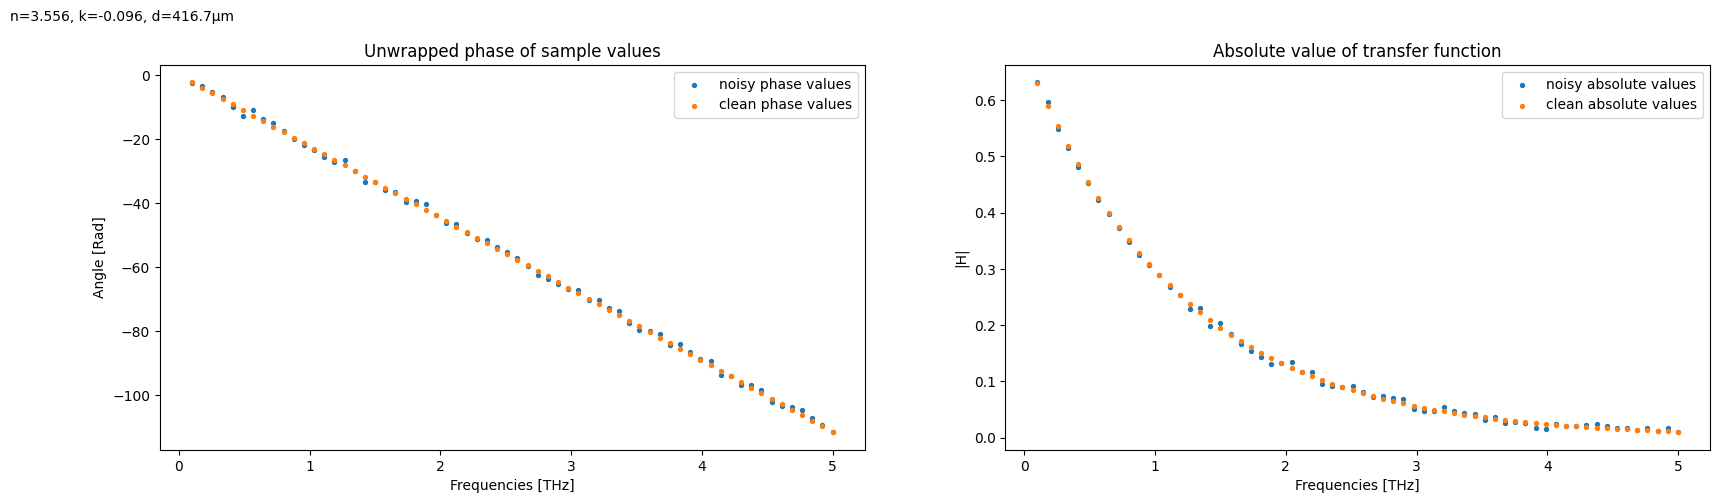

In [4]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

axs[0].scatter(freqs_THz, phi_values, s=8, label='noisy phase values')
axs[0].scatter(freqs_THz, phi_values_clean, s=8, label='clean phase values')
axs[0].set_title('Unwrapped phase of sample values')
axs[0].set_xlabel('Frequencies [THz]')
axs[0].set_ylabel('Angle [Rad]')

axs[1].scatter(freqs_THz, H_values, s=8, label='noisy absolute values')
axs[1].scatter(freqs_THz, H_values_clean, s=8, label='clean absolute values')
axs[1].set_title('Absolute value of transfer function')
axs[1].set_xlabel('Frequencies [THz]')
axs[1].set_ylabel('|H|')

# Annotate with n, k, d values
axs[1].set_ylabel('|H|')

# Add a label at the top-left of the entire figure (outside the subplots)
fig.text(0.05, 0.99, f'n={n:.3f}, k={k:.3f}, d={1e6*d:.1f}µm', 
         verticalalignment='top', horizontalalignment='left', 
         bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.5'))

axs[0].legend()
axs[1].legend()
plt.show()

In [5]:
# TODO: Copy grid-search approach to here


def grid_search(n0, k0, d0, H_values, phi_values, freqs_ang, H_th_function, loss):
    """
    Performs a grid search to optimize n, k, and d parameters by minimizing the loss function.

    Parameters:
    - n0 (float): Initial guess for n.
    - k0 (float): Initial guess for k.
    - d0 (float): Initial guess for d.
    - H_values (list/array): Measured amplitude values.
    - phi_values (list/array): Measured phase values.
    - freqs_ang (list/array): Frequency values (angular).
    - H_th_function (function): Function to compute theoretical transfer function.
    - loss (function): Loss function to compare predicted and actual values.

    Returns:
    - best_params (dict): Dictionary containing optimal values for n, k, and d.
    - min_loss (float): Minimum loss achieved.
    """

    min_loss = np.inf
    best_params = {'n': 0, 'k': 0, 'd': 0}

    for ii in range(3):
        n_pred = n0 + ii * 0.01
        for ij in range(3):
            k_pred = k0 + ij * 0.005
            for ik in range(3):
                d_pred = d0 + ik * 0.0001

                # Compute the theoretical transfer function
                tf_values_pred = [H_th_function((n_pred + k_pred * 1j), f, d_pred) for f in freqs_ang]
                H_values_pred = np.abs(tf_values_pred)
                phi_values_pred = np.unwrap(np.angle(tf_values_pred))

                # Compute loss
                l = loss(H_values, H_values_pred, phi_values, phi_values_pred)

                if l < min_loss:
                    min_loss = l
                    best_params = {'n': n_pred, 'k': k_pred, 'd': d_pred}

                #print(f"{n_pred=:.2f}, {k_pred=:.3f}, {d_pred=:.4f}, Loss: {l:.6f}")

    return best_params, min_loss

grid_search(n0=2.0, k0=-0.05, d0=0.0004, H_values=H_values, phi_values=phi_values, freqs_ang=freqs_ang, H_th_function=H_th_function, loss=loss)


({'n': 2.02, 'k': -0.05, 'd': 0.0006000000000000001}, 24.196341014871514)

In [6]:
# Convert experimental data to PyTorch tensors
w_tensor = torch.tensor(freqs_ang, dtype=torch.float32)
H_exp_tensor = torch.tensor(H_values, dtype=torch.float32)  # Amplitude
phi_exp_tensor = torch.tensor(phi_values, dtype=torch.float32)  # Phase

# Define PyTorch Model
class TransferFunctionModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # Use transformed parameters to enforce constraints
        self.n_raw = torch.nn.Parameter(torch.tensor(np.log(3.0), dtype=torch.float32))  # log ensures n > 0
        self.k_raw = torch.nn.Parameter(torch.tensor(np.log(0.05), dtype=torch.float32))  # log of positive, negated later
        self.d_raw = torch.nn.Parameter(torch.tensor(np.log(400e-6), dtype=torch.float32))  # log ensures d > 0

    def forward(self, w):
        # Apply transformations to enforce constraints
        n = torch.exp(self.n_raw)  # Exp ensures n > 0
        k = -torch.exp(self.k_raw)  # -Exp ensures k < 0
        d = torch.exp(self.d_raw)  # Exp ensures d > 0
        
        n_complex = n + 1j * k
        H_th = (4 * n_complex) / ((n_complex + 1) ** 2) * torch.exp(-1j * (n_complex - 1) * w * d / c)
        return H_th

# Initialize model and optimizer
model = TransferFunctionModel()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training Loop
num_epochs = 1000
for epoch in range(num_epochs):
    optimizer.zero_grad()
    
    # Compute predicted transfer function
    H_pred = model(w_tensor)

    # Compute amplitude and phase
    H_pred_amp = torch.abs(H_pred)
    H_pred_phase = torch.angle(H_pred)

    # Unwrap the phase using NumPy
    H_pred_phase_unwrapped = np.unwrap(H_pred_phase.detach().cpu().numpy())  # Convert to NumPy, unwrap, and convert back to tensor

    # Convert the unwrapped phase back to a PyTorch tensor
    H_pred_phase_unwrapped = torch.tensor(H_pred_phase_unwrapped, dtype=torch.float32).to(H_pred.device)

    # Compute loss
    loss_amp = torch.mean((H_pred_amp - H_exp_tensor) ** 2)
    loss_phase = torch.mean((H_pred_phase_unwrapped - phi_exp_tensor) ** 2) / torch.var(phi_exp_tensor)  # Normalize phase loss
    loss = loss_amp + loss_phase

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Print progress
    if epoch % 100 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item()}")

# Optimized parameters
print(f"Optimized n: {torch.exp(model.n_raw).item()}, k: {-torch.exp(model.k_raw).item()}, d: {torch.exp(model.d_raw).item()}")

Epoch 0: Loss = 0.2753669321537018
Epoch 100: Loss = 0.024927008897066116
Epoch 200: Loss = 0.05780356004834175
Epoch 300: Loss = 0.25687968730926514
Epoch 400: Loss = 0.5002470016479492
Epoch 500: Loss = 0.46160006523132324
Epoch 600: Loss = 0.5771912932395935
Epoch 700: Loss = 0.6411694884300232
Epoch 800: Loss = 0.6642290353775024
Epoch 900: Loss = 0.6603630185127258
Optimized n: 3.8549318313598633, k: -0.06873736530542374, d: 0.0005499021499417722


In [ ]:
# TODO: 
# Test the outputs by plotting.
# Test different initial conditions.
# Test single thickness back-prop.
# Create training plots.